In [1]:
# Not needed.  Code is embedded in stress modules.
# Adds lag and exponent columns to hist_all.csv and CCARscen_all.csv tables.
# 20170410: expanded to handle CCAR sUE adjustments through 2017
# creates UE_adj.csv file for sUE calcs
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## new file for econ variables only:  add lags, exponents, then save for future use.
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

In [3]:
## history vars: 4q lags & 4q differences for UE, HPI, CRE (also, try 6q & 8q lags for UE only)
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']
hs['UE_42'] = hs['UE_4'] * hs['UE_4']

hsx = hs.copy()
hsx[hsx['Date']>'2001-01-01'].tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  ...    \
159 2015-12-31    0.9    1.8   3.0   3.4  5.0  0.8  0.1  1.6   2.2  ...     
160 2016-03-31    0.8    1.3   2.1   2.4  4.9 -0.3  0.3  1.4   2.0  ...     
161 2016-06-30    1.4    3.7   2.9   5.0  4.9  2.5  0.3  1.3   1.8  ...     
162 2016-09-30    3.5    5.0   2.6   4.1  4.9  1.6  0.3  1.2   1.6  ...     
163 2016-12-31    3.1    6.1   1.6   4.5  4.7  3.4  0.4  1.7   2.2  ...     

     Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  UE_42  
159    3.3  21101.0  174.0  277.0  24.4   5.7  165.0  253.0  25.00  32.49  
160    3.5  21179.0  177.0  278.0  28.1   5.6  168.0  262.0  24.01  31.36  
161    3.5  21621.0  179.0  283.0  25.8   5.4  170.0  266.0  24.01  29.16  
162    3.5  22469.0  182.0  290.0  18.1   5.2  172.0  272.0  24.01  27.04  
163    3.5  23277.0  183.0  294.0  22.5   5.0  174.0  277.0  22.09  25.00  

[5 rows x 22 columns]

In [4]:
hsx.to_csv("hist_lagexp.csv")
hsy = hsx[hsx['Date']>'2001-01-01'].copy()
hsy.set_index('Date',drop=True,inplace=True)
hsy.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  ...    \
Date                                                                 ...     
2015-12-31    0.9    1.8   3.0   3.4  5.0  0.8  0.1  1.6   2.2  4.6  ...     
2016-03-31    0.8    1.3   2.1   2.4  4.9 -0.3  0.3  1.4   2.0  4.6  ...     
2016-06-30    1.4    3.7   2.9   5.0  4.9  2.5  0.3  1.3   1.8  4.1  ...     
2016-09-30    3.5    5.0   2.6   4.1  4.9  1.6  0.3  1.2   1.6  3.7  ...     
2016-12-31    3.1    6.1   1.6   4.5  4.7  3.4  0.4  1.7   2.2  4.1  ...     

            Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  \
Date                                                                        
2015-12-31    3.3  21101.0  174.0  277.0  24.4   5.7  165.0  253.0  25.00   
2016-03-31    3.5  21179.0  177.0  278.0  28.1   5.6  168.0  262.0  24.01   
2016-06-30    3.5  21621.0  179.0  283.0  25.8   5.4  170.0  266.0  24.01   
2016-09-30    3.5  22469.0  182.0  290.0  18.1   5.2  172.0  272.0  24.01   
2016-12-31    3.5  23277.0  183.0  294.0  22.5   5.0  174.0  277.0  22.09   

            UE_42  
Date               
2015-12-31  32.49  
2016-03-31  31.36  
2016-06-30  29.16  
2016-09-30  27.04  
2016-12-31  25.00  

[5 rows x 21 columns]

In [5]:
hsy.columns

Index(['rGDPg', 'nGDPg', 'rDIg', 'nDIg', 'UE', 'CPI', 'T3m', 'T5y', 'T10y',
       'BBB', 'Mort', 'Prime', 'DJ', 'HPI', 'CRE', 'VIX', 'UE_4', 'HPI_4',
       'CRE_4', 'UE2', 'UE_42'],
      dtype='object')

In [6]:
ccy = cc.copy()
ccy['UE_4'] = ccy.groupby(['CCAR','Scen'])[['UE']].shift(4)
ccy['HPI_4'] = ccy.groupby(['CCAR','Scen'])[['HPI']].shift(4)
ccy['CRE_4'] = ccy.groupby(['CCAR','Scen'])[['CRE']].shift(4)
#test.columns = ['UE_4','HPI_4','CRE_4']
ccy.tail(26)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE  CPI  T3m  ...    \
212  2017  Adv 2017-06-30   -2.8   -0.7  -0.6   1.1   5.8  1.8  0.1  ...     
213  2017  Adv 2017-09-30   -2.0    0.0  -0.5   1.1   6.3  1.8  0.1  ...     
214  2017  Adv 2017-12-31   -1.5    0.5  -0.5   1.2   6.8  1.8  0.1  ...     
215  2017  Adv 2018-03-31   -0.5    1.4   0.2   1.9   7.1  1.8  0.1  ...     
216  2017  Adv 2018-06-30    1.0    3.0   0.6   2.4   7.3  2.0  0.1  ...     
217  2017  Adv 2018-09-30    1.4    3.3   1.0   2.7   7.4  2.0  0.1  ...     
218  2017  Adv 2018-12-31    2.6    4.4   1.5   3.4   7.3  2.1  0.1  ...     
219  2017  Adv 2019-03-31    2.6    4.3   1.6   3.5   7.2  2.1  0.1  ...     
220  2017  Adv 2019-06-30    3.0    4.6   2.1   3.8   7.1  2.0  0.1  ...     
221  2017  Adv 2019-09-30    3.0    4.5   2.2   3.8   7.0  2.0  0.1  ...     
222  2017  Adv 2019-12-31    3.0    4.5   2.1   3.8   6.9  1.9  0.1  ...     
223  2017  Adv 2020-03-31    3.0    4.5   2.0   3.5   6.8  1.8  0.1  ...     
224  2017  Sev 2016-12-31    3.1    6.1   1.6   4.5   4.7  3.4  0.4  ...     
225  2017  Sev 2017-03-31   -5.1   -2.7  -1.0   0.5   5.6  1.5  0.1  ...     
226  2017  Sev 2017-06-30   -7.5   -5.5  -4.0  -2.7   6.9  1.3  0.1  ...     
227  2017  Sev 2017-09-30   -5.9   -4.1  -3.9  -2.6   8.0  1.3  0.1  ...     
228  2017  Sev 2017-12-31   -5.1   -3.3  -3.7  -2.3   8.9  1.4  0.1  ...     
229  2017  Sev 2018-03-31   -3.0   -1.4  -2.5  -1.1   9.6  1.5  0.1  ...     
230  2017  Sev 2018-06-30    0.0    1.6  -1.4   0.2   9.8  1.7  0.1  ...     
231  2017  Sev 2018-09-30    0.7    2.3  -0.4   1.1  10.0  1.7  0.1  ...     
232  2017  Sev 2018-12-31    3.0    4.5   0.8   2.4   9.9  1.9  0.1  ...     
233  2017  Sev 2019-03-31    3.0    4.4   1.4   2.9   9.8  1.8  0.1  ...     
234  2017  Sev 2019-06-30    3.9    5.1   2.2   3.7   9.6  1.7  0.1  ...     
235  2017  Sev 2019-09-30    3.9    5.0   2.5   3.8   9.4  1.6  0.1  ...     
236  2017  Sev 2019-12-31    3.9    4.9   2.6   3.8   9.1  1.6  0.1  ...     
237  2017  Sev 2020-03-31    3.9    4.8   2.5   3.6   8.9  1.4  0.1  ...     

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4  
212  5.9   4.9    3.3  15042.0  179.0  283.0  32.7   NaN    NaN    NaN  
213  6.1   5.1    3.3  14290.0  176.0  275.0  34.4   NaN    NaN    NaN  
214  6.2   5.2    3.2  13982.0  173.0  267.0  32.0   4.7  183.0  294.0  
215  6.0   5.2    3.2  14367.0  170.0  259.0  28.5   5.2  181.0  291.0  
216  5.8   5.2    3.2  15001.0  166.0  254.0  25.8   5.8  179.0  283.0  
217  5.6   5.1    3.2  15693.0  163.0  250.0  23.6   6.3  176.0  275.0  
218  5.4   5.1    3.2  16603.0  161.0  249.0  21.6   6.8  173.0  267.0  
219  5.2   5.0    3.2  17519.0  161.0  249.0  20.1   7.1  170.0  259.0  
220  5.0   4.9    3.2  18514.0  161.0  251.0  18.7   7.3  166.0  254.0  
221  4.8   4.8    3.2  19243.0  162.0  255.0  18.2   7.4  163.0  250.0  
222  4.7   4.8    3.2  20025.0  163.0  259.0  17.6   7.3  161.0  249.0  
223  4.5   4.7    3.2  20867.0  164.0  262.0  17.3   7.2  161.0  249.0  
224  4.1   3.9    3.5  23277.0  183.0  294.0  22.5   NaN    NaN    NaN  
225  5.5   4.0    3.3  15374.0  179.0  288.0  68.7   NaN    NaN    NaN  
226  6.0   4.3    3.3  13538.0  174.0  270.0  50.9   NaN    NaN    NaN  
227  6.3   4.5    3.3  12295.0  168.0  251.0  57.2   NaN    NaN    NaN  
228  6.4   4.6    3.2  11704.0  162.0  234.0  49.3   4.7  183.0  294.0  
229  6.1   4.5    3.2  12338.0  156.0  218.0  39.1   5.6  179.0  288.0  
230  5.7   4.4    3.2  13325.0  148.0  206.0  31.9   6.9  174.0  270.0  
231  5.4   4.4    3.2  14348.0  142.0  196.0  26.7   8.0  168.0  251.0  
232  5.0   4.3    3.2  15625.0  138.0  193.0  22.2   8.9  162.0  234.0  
233  4.7   4.1    3.2  17070.0  137.0  192.0  19.3   9.6  156.0  218.0  
234  4.3   4.0    3.2  18739.0  138.0  194.0  16.8   9.8  148.0  206.0  
235  4.0   3.9    3.2  19909.0  140.0  198.0  16.0  10.0  142.0  196.0  
236  3.8   3.9    3.2  21186.0  142.0  203.0  14.9   9.9  138.0  193.0  


In [7]:
for i in np.arange(len(ccy)):
  if np.isnan(ccy.ix[i]['UE_4']):
    yr = ccy.ix[i]['Date'].year - 1
    mn = ccy.ix[i]['Date'].month
    dy = ccy.ix[i]['Date'].day
    dd = str(datetime(yr,mn,dy))[0:7]
    xu = hsy[dd]['UE'].values
    ccy.loc[i,'UE_4'] = xu
    xh = hsy[dd]['HPI'].values
    ccy.loc[i,'HPI_4'] = xh
    xc = hsy[dd]['CRE'].values
    ccy.loc[i,'CRE_4'] = xc

ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m   ...    \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0   ...     
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1   ...     
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1   ...     
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1   ...     
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1   ...     
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1   ...     
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1   ...     
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1   ...     

    BBB  Mort  Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4  
0  4.90  4.20    NaN  11677.00  132.00  177.00  48.00   9.5  135.00  167.00  
1  4.52  4.21    NaN  11936.09  137.21  172.17  35.97   9.5  133.00  173.00  
2  4.55  4.17    NaN  12090.22  137.55  173.29  35.08   9.0  132.00  180.00  
3  4.59  4.15    NaN  12242.03  137.89  175.43  31.83   9.1  132.00  177.00  
4  4.74  4.19    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  
5  4.89  4.24    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  
6  5.15  4.34    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  
7  5.32  4.41    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  

[8 rows x 22 columns]

In [8]:
ccy['UE2'] = ccy['UE'] * ccy['UE']
ccy['UE_42'] = ccy['UE_4'] * ccy['UE_4']
ccy.to_csv('CCARscen_lagexp.csv')
ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m  ...    \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0  ...     
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1  ...     
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1  ...     
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1  ...     
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1  ...     
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1  ...     
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1  ...     
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1  ...     

   Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4      UE2  \
0    NaN  11677.00  132.00  177.00  48.00   9.5  135.00  167.00  81.0000   
1    NaN  11936.09  137.21  172.17  35.97   9.5  133.00  173.00  82.8100   
2    NaN  12090.22  137.55  173.29  35.08   9.0  132.00  180.00  82.8100   
3    NaN  12242.03  137.89  175.43  31.83   9.1  132.00  177.00  81.0000   
4    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  79.2100   
5    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  79.2100   
6    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  75.5161   
7    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  71.9104   

   UE_42  
0  90.25  
1  90.25  
2  81.00  
3  82.81  
4  81.00  
5  82.81  
6  82.81  
7  81.00  

[8 rows x 24 columns]

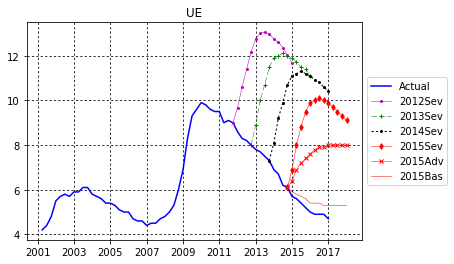

In [9]:
vv = 'UE'
hsx1 = hsx[hsx['Date']>'2001-01-01']
hsx1.set_index('Date', drop=True, inplace=True)
cc2 = ccy[['Date','CCAR','Scen',vv]]
cc2['YrSc'] = cc2.apply(lambda x: str(x['CCAR'])+x['Scen'],axis=1)
cc2p = cc2.pivot('Date','YrSc',vv)
#cc2p.head()
hsx2 = hsx1.merge(cc2p, how='outer', left_index=True, right_index=True)
#hsx2.tail()

x = list(hsx2.index)

plt.plot(x,hsx2[vv],c='b',label='Actual')
plt.plot(x,hsx2['2012Sev'],ls='-',c='m',lw=.5,marker='.',ms=4,label='2012Sev')
plt.plot(x,hsx2['2013Sev'],ls='--',c='g',lw=.5,marker='+',ms=4,label='2013Sev')
plt.plot(x,hsx2['2014Sev'],ls=':',c='k',lw=1,marker='.',ms=4,label='2014Sev')
plt.plot(x,hsx2['2015Sev'],c='r',lw=.5,marker='d',ms=4,label='2015Sev')
plt.plot(x,hsx2['2015Adv'],c='r',lw=.5,marker='x',ms=4,label='2015Adv')
plt.plot(x,hsx2['2015Bas'],c='r',lw=.5,label='2015Bas')
plt.title(vv)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.savefig(vv+'_chart.png', dpi=400, bbox_inches='tight')
plt.show()

In [10]:
hsue = pd.DataFrame(hsy.ix['2001':'2019']['UE'])
hsue.reset_index(drop=False, inplace=True)
hsue.tail()

Date   UE
59 2015-12-31  5.0
60 2016-03-31  4.9
61 2016-06-30  4.9
62 2016-09-30  4.9
63 2016-12-31  4.7

In [11]:
ccs = ccy[ccy['Scen']=='Sev'][['CCAR','Date','UE']]
ccs = ccs.pivot('Date','CCAR','UE')
ccs.reset_index(drop=False, inplace=True)
ccs.columns = ['Date','u12','u13','u14','u15','u16','u17']
ccs.tail()

Date  u12  u13  u14  u15  u16  u17
30 2019-03-31  NaN  NaN  NaN  NaN  8.9  9.8
31 2019-06-30  NaN  NaN  NaN  NaN  NaN  9.6
32 2019-09-30  NaN  NaN  NaN  NaN  NaN  9.4
33 2019-12-31  NaN  NaN  NaN  NaN  NaN  9.1
34 2020-03-31  NaN  NaN  NaN  NaN  NaN  8.9

In [12]:
hsue2 = hsue.merge(ccs,how='outer',on='Date')
hsue2.set_index('Date', drop=True, inplace=True)
hsue2.tail()

UE  u12  u13  u14  u15  u16  u17
Date                                        
2019-03-31 NaN  NaN  NaN  NaN  NaN  8.9  9.8
2019-06-30 NaN  NaN  NaN  NaN  NaN  NaN  9.6
2019-09-30 NaN  NaN  NaN  NaN  NaN  NaN  9.4
2019-12-31 NaN  NaN  NaN  NaN  NaN  NaN  9.1
2020-03-31 NaN  NaN  NaN  NaN  NaN  NaN  8.9

In [13]:
hsue2['Qn'] = hsue2.index.year * 4 + hsue2.index.month /3
hsue2['Qn'] = hsue2['Qn'].astype(int)
hsue2.tail()

UE  u12  u13  u14  u15  u16  u17    Qn
Date                                              
2019-03-31 NaN  NaN  NaN  NaN  NaN  8.9  9.8  8077
2019-06-30 NaN  NaN  NaN  NaN  NaN  NaN  9.6  8078
2019-09-30 NaN  NaN  NaN  NaN  NaN  NaN  9.4  8079
2019-12-31 NaN  NaN  NaN  NaN  NaN  NaN  9.1  8080
2020-03-31 NaN  NaN  NaN  NaN  NaN  NaN  8.9  8081

In [14]:
mx = hsue2[['UE','u12','u13','u14','u15','u16','u17']].max()
mx = pd.DataFrame(mx)
mx.columns = ['mx']
mxdct = mx.to_dict()
mxdct['mx']

{'UE': 9.9000000000000004,
 'u12': 13.050000000000001,
 'u13': 12.1,
 'u14': 11.300000000000001,
 'u15': 10.1,
 'u16': 10.0,
 'u17': 10.0}

In [15]:
mxd = hsue2[hsue2['UE']==mxdct['mx']['UE']]['Qn']
mxd12 = hsue2[hsue2['u12']==mxdct['mx']['u12']]['Qn']
mxd13 = hsue2[hsue2['u13']==mxdct['mx']['u13']]['Qn']
mxd14 = hsue2[hsue2['u14']==mxdct['mx']['u14']]['Qn']
mxd15 = hsue2[hsue2['u15']==mxdct['mx']['u15']]['Qn']
mxd16 = hsue2[hsue2['u16']==mxdct['mx']['u16']]['Qn']
mxd17 = hsue2[hsue2['u17']==mxdct['mx']['u17']]['Qn']
mxd15

Date
2016-06-30    8066
Name: Qn, dtype: int32

In [16]:
mxq = pd.DataFrame(pd.concat([mxd,mxd12,mxd13,mxd14,mxd15,mxd16,mxd17]))
mxq.reset_index(drop=False, inplace=True)
ux=pd.Series(['UE','u12','u13','u14','u15','u16','u17'])
mxq = mxq.assign(ux=ux.values)
mxq.set_index('ux',drop=True,inplace=True)
mxq

Date    Qn
ux                  
UE  2009-12-31  8040
u12 2013-06-30  8054
u13 2014-06-30  8058
u14 2015-06-30  8062
u15 2016-06-30  8066
u16 2017-09-30  8071
u17 2018-09-30  8075

In [17]:
mx2 = mx.merge(mxq, how='inner', left_index=True, right_index=True)
mx2.reset_index(drop=False,inplace=True)
mx2

index     mx       Date    Qn
0    UE   9.90 2009-12-31  8040
1   u12  13.05 2013-06-30  8054
2   u13  12.10 2014-06-30  8058
3   u14  11.30 2015-06-30  8062
4   u15  10.10 2016-06-30  8066
5   u16  10.00 2017-09-30  8071
6   u17  10.00 2018-09-30  8075

In [18]:
hmx = mx2[mx2['index']=='UE']['mx'][0]
hqn = mx2[mx2['index']=='UE']['Qn'][0]

# calcs incremental adjustment to curr UE rate per period:
for i in np.arange(len(mx2)):
  mx2.loc[i,'adj'] = (1 - hmx / mx2.loc[i,'mx']  )
  mx2.loc[i,'inc'] = (1 - hmx / mx2.loc[i,'mx']  )  /(mx2.loc[i,'Qn'] - hqn)

mx2

index     mx       Date    Qn       adj       inc
0    UE   9.90 2009-12-31  8040  0.000000       NaN
1   u12  13.05 2013-06-30  8054  0.241379  0.017241
2   u13  12.10 2014-06-30  8058  0.181818  0.010101
3   u14  11.30 2015-06-30  8062  0.123894  0.005632
4   u15  10.10 2016-06-30  8066  0.019802  0.000762
5   u16  10.00 2017-09-30  8071  0.010000  0.000323
6   u17  10.00 2018-09-30  8075  0.010000  0.000286

In [19]:
hsue2.to_csv('uescaledata.csv')

In [20]:
mx2.to_csv("uescaleparam.csv")

In [21]:
ues = pd.DataFrame(hsue2['Qn'])
ues['adj'] = 1
ues.reset_index(drop=False, inplace=True)
ues.head()

Date    Qn  adj
0 2001-03-31  8005    1
1 2001-06-30  8006    1
2 2001-09-30  8007    1
3 2001-12-31  8008    1
4 2002-03-31  8009    1

In [22]:
## 2012 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u12']['Date']))

inc = np.float(mx2[mx2['index']=='u12']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u12']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj12'}, inplace=True)
ues.head()

Date    Qn  adj12
0 2001-03-31  8005    1.0
1 2001-06-30  8006    1.0
2 2001-09-30  8007    1.0
3 2001-12-31  8008    1.0
4 2002-03-31  8009    1.0

In [23]:
## 2013 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u13']['Date']))

inc = np.float(mx2[mx2['index']=='u13']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u13']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj13'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13
0 2001-03-31  8005    1.0    1.0
1 2001-06-30  8006    1.0    1.0
2 2001-09-30  8007    1.0    1.0
3 2001-12-31  8008    1.0    1.0
4 2002-03-31  8009    1.0    1.0

In [24]:
## 2014 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u14']['Date']))

inc = np.float(mx2[mx2['index']=='u14']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u14']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj14'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14
0 2001-03-31  8005    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0

In [25]:
## 2015 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u15']['Date']))

inc = np.float(mx2[mx2['index']=='u15']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u15']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj15'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15
0 2001-03-31  8005    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0

In [26]:
## 2016 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u16']['Date']))

inc = np.float(mx2[mx2['index']=='u16']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u16']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj16'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0

In [27]:
## 2017 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u17']['Date']))

inc = np.float(mx2[mx2['index']=='u17']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u17']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj17'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0

In [28]:
ues.drop('Qn', axis=1, inplace=True)
ues.tail()

Date     adj12     adj13     adj14     adj15  adj16  adj17
72 2019-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99
73 2019-06-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99
74 2019-09-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99
75 2019-12-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99
76 2020-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99

In [29]:
ues.to_csv("UE_adj.csv")

In [30]:
ues[35:64]

Date     adj12     adj13     adj14     adj15     adj16     adj17
35 2009-12-31  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
36 2010-03-31  0.982759  0.989899  0.994368  0.999238  0.999677  0.999714
37 2010-06-30  0.965517  0.979798  0.988737  0.998477  0.999355  0.999429
38 2010-09-30  0.948276  0.969697  0.983105  0.997715  0.999032  0.999143
39 2010-12-31  0.931034  0.959596  0.977474  0.996954  0.998710  0.998857
40 2011-03-31  0.913793  0.949495  0.971842  0.996192  0.998387  0.998571
41 2011-06-30  0.896552  0.939394  0.966211  0.995430  0.998065  0.998286
42 2011-09-30  0.879310  0.929293  0.960579  0.994669  0.997742  0.998000
43 2011-12-31  0.862069  0.919192  0.954948  0.993907  0.997419  0.997714
44 2012-03-31  0.844828  0.909091  0.949316  0.993145  0.997097  0.997429
45 2012-06-30  0.827586  0.898990  0.943685  0.992384  0.996774  0.997143
46 2012-09-30  0.810345  0.888889  0.938053  0.991622  0.996452  0.996857
47 2012-12-31  0.793103  0.878788  0.932422  0.990861  0.996129  0.996571
48 2013-03-31  0.775862  0.868687  0.926790  0.990099  0.995806  0.996286
49 2013-06-30  0.758621  0.858586  0.921158  0.989337  0.995484  0.996000
50 2013-09-30  0.758621  0.848485  0.915527  0.988576  0.995161  0.995714
51 2013-12-31  0.758621  0.838384  0.909895  0.987814  0.994839  0.995429
52 2014-03-31  0.758621  0.828283  0.904264  0.987053  0.994516  0.995143
53 2014-06-30  0.758621  0.818182  0.898632  0.986291  0.994194  0.994857
54 2014-09-30  0.758621  0.818182  0.893001  0.985529  0.993871  0.994571
55 2014-12-31  0.758621  0.818182  0.887369  0.984768  0.993548  0.994286
56 2015-03-31  0.758621  0.818182  0.881738  0.984006  0.993226  0.994000
57 2015-06-30  0.758621  0.818182  0.876106  0.983244  0.992903  0.993714
58 2015-09-30  0.758621  0.818182  0.876106  0.982483  0.992581  0.993429
59 2015-12-31  0.758621  0.818182  0.876106  0.981721  0.992258  0.993143
60 2016-03-31  0.758621  0.818182  0.876106  0.980960  0.991935  0.992857
61 2016-06-30  0.758621  0.818182  0.876106  0.980198  0.991613  0.992571
62 2016-09-30  0.758621  0.818182  0.876106  0.980198  0.991290  0.992286
63 2016-12-31  0.758621  0.818182  0.876106  0.980198  0.990968  0.992000